# On Analyzing Real World Time Series for Forecasting: Generated Random Walk TS
- NOTES: [RW](https://detraviousjbrinkley.notion.site/Random-Walk-RW-Drunkard-s-Walk-DW-70ef3c2fd4324572adf86b7403ff3690?pvs=4) by Detravious J.B.
- TUTORIAL: [A Gentle Introduction to the Random Walk for Times Series Forecasting with Python](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/) by Jason Brownlee

## TODOs
- [ ] Fix the steps

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from ts_models import Model, RandomWalk, AR, EvaluationMetric
from data_loader import build_any_univariate_time_series
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Generated Stationary Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc)
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Raw Data
10. Plot Autocorrelation and Partial Autocorrelation
11. Split Data
12. Initialize Autoregressive AR(p) Model
13. Predict Forecasts
14. Plot Actual Forecasts vs Predicted Forecasts
15. Follow-up

### Load Raw Data

In [2]:
file = "../../datasets/generated_random_walk_ts.npy"

In [3]:
generated_stationary_ts = build_any_univariate_time_series(file)
generated_stationary_ts

UnivariateTimeSeries(Observations)

In [4]:
gsts_df = generated_stationary_ts.get_as_df()
gsts_df

,Observations
Timestamp,
0,-1
1,0
2,1
3,0
4,-1
...,...
995,54
996,55
997,54


### Plot Raw Data

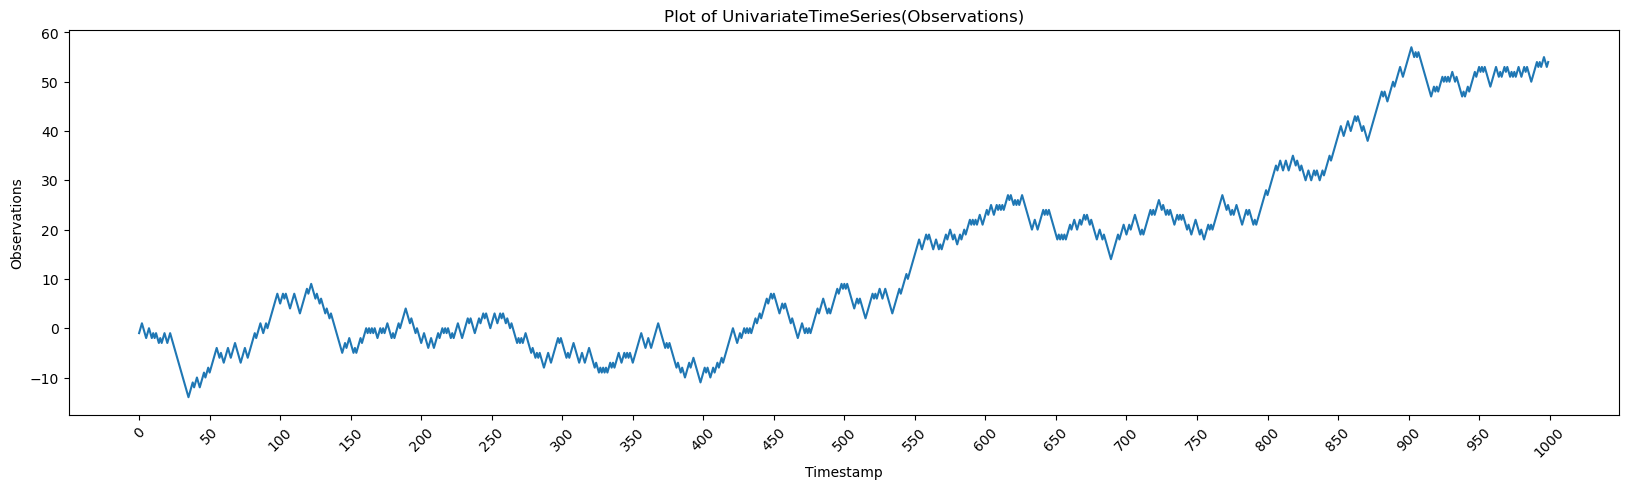

In [5]:
generated_stationary_ts.plot(tick_skip=50)

### Get Descriptive Statistics

In [6]:
generated_stationary_ts.get_statistics()

,Observations
count,1000.000000
mean,13.738000
std,19.005698
min,-14.000000
25%,-2.000000
50%,6.000000
75%,24.000000
max,57.000000


In [7]:
generated_stationary_ts.max_min_range()

{'Max': Observations    57
 dtype: int64,
 'Min': Observations   -14
 dtype: int64,
 'Range': Observations    71
 dtype: int64}

### Check Stationarity of Raw Data

In [8]:
generated_stationary_ts.stationarity_test(gsts_df)

ADF Statistic: 0.341605
p-value: 0.979175 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


- The p-value and the TS being non-stationary are correct as RW observations are dependent on each other, hence NOT random.

### Plot Autocorrelation and Partial Autocorrelation
- Shows how the relationship between the current observation and it's historical observations correlate at that specific k-th lag.

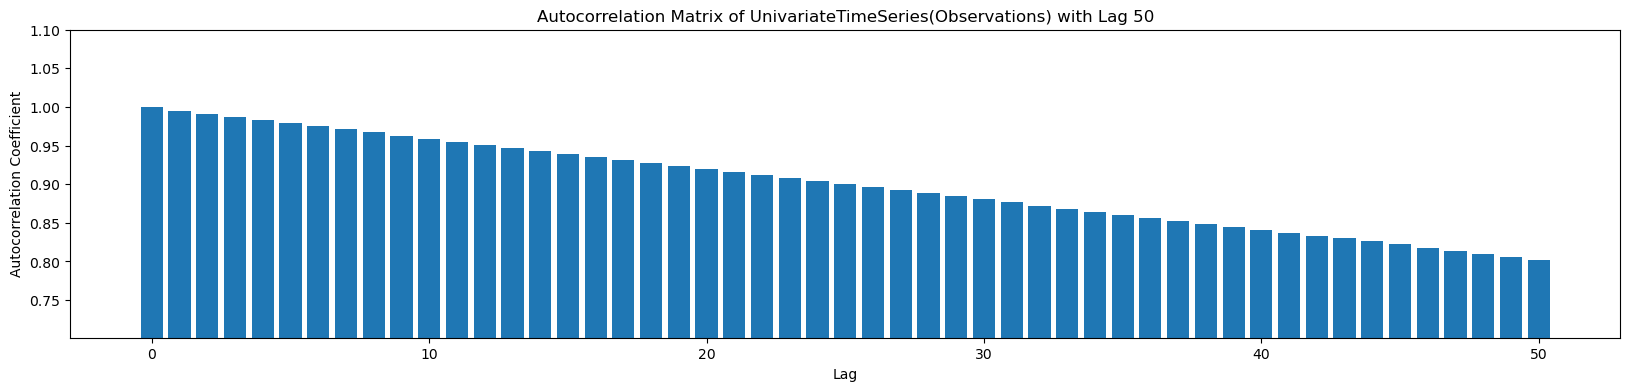

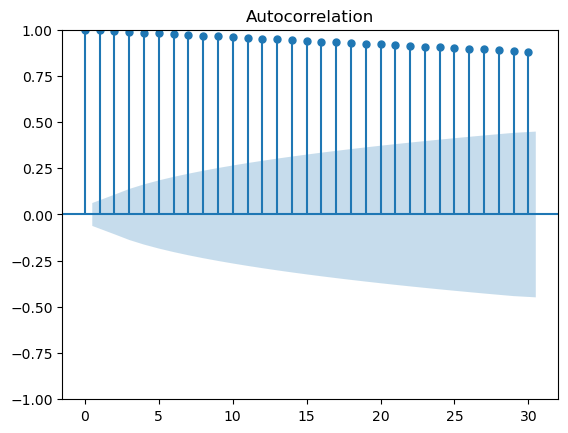

In [9]:
# Change to 500 to show a similar representation that Jason has
generated_stationary_ts.plot_autocorrelation(50)

- We first observe that all the values are correlated with the current $ z_t $ and with each other, hence dependence.
- There exists a trend.
- All values fall outside of blue region, hence non-stationary.
- Values starting at the ~370-th lag goes to negative. This implies that $ z_t $ depends on all lags up to ~370-th lag. 

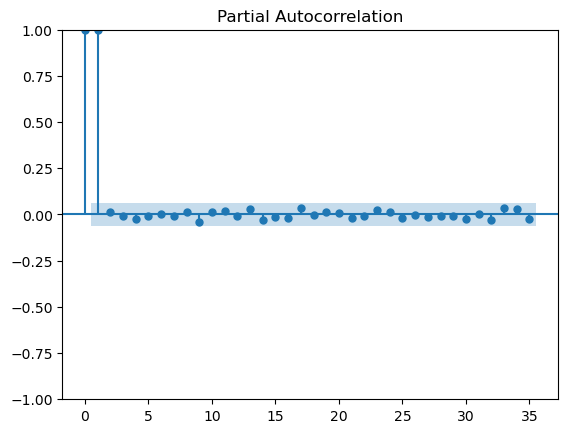

In [10]:
generated_stationary_ts.plot_partial_autocorrelation(35)

- Partial ACorr removes the correlation (also dependence), so this looks okay. I assumed it would've removed the correlation from current observation and the immediately previous observation as well, but it didn't. Why?
- An exponential decay after lag 2.
- All values starting at lag 2 are within the confidence intervals. Thus, TS is stationary at this point and the current observation is independent of these previous observations starting at lag 2. 

- Only printing the below bc this is what Jason does. Want to ensure accurate reproducibility. 

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

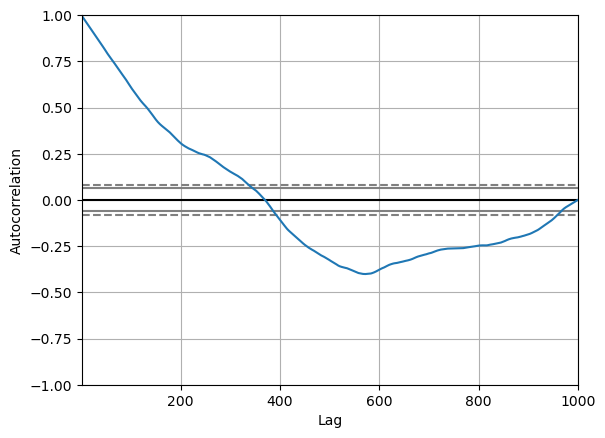

In [11]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(generated_stationary_ts.get_series())

- How to interpret this type of ACorr plot? Looks slightly different from above. 
- P 97 in Introduction to TSF with Python, Jason Brownlee states that "we generally see the expected trend, in this case across the first few hundred lag observations."

### Initialize & Predict (RW) Model
- We use the raw TS instead of the differenced TS to make predictions on.

#### Split Data

In [12]:
random_walk = generated_stationary_ts.get_series()
# random_walk

In [13]:
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]
len(train), len(test)

(660, 340)

In [14]:
train_raw, validation_raw, test_raw = generated_stationary_ts.get_train_validation_test_split(0.66, 0.0)

0 660
660 660
660 1000


In [15]:
train_data_df = train_raw.get_as_df()
len(train_data_df), train_data_df

(660,
            UnivariateTimeSeries(Observations)[0:660]
 Timestamp                                           
 0                                                 -1
 1                                                  0
 2                                                  1
 3                                                  0
 4                                                 -1
 ...                                              ...
 655                                               18
 656                                               19
 657                                               18
 658                                               19
 659                                               20
 
 [660 rows x 1 columns])

In [16]:
expected_forecasts_df = test_raw.get_as_df()
len(expected_forecasts_df)

340

In [17]:
rw_model_class = RandomWalk()

rw_predictions = rw_model_class.predict(train_data_df, expected_forecasts_df)

In [18]:
# rw_predictions

In [19]:
rw_mse_gsts = EvaluationMetric.eval_mse(expected_forecasts_df, rw_predictions, per_element=False)
rw_mse_gsts

Test MSE: 1.000


In [20]:
rw_rmse_gsts = EvaluationMetric.eval_rmse(expected_forecasts_df, rw_predictions, per_element=False)
rw_rmse_gsts

Test RMSE: 1.000


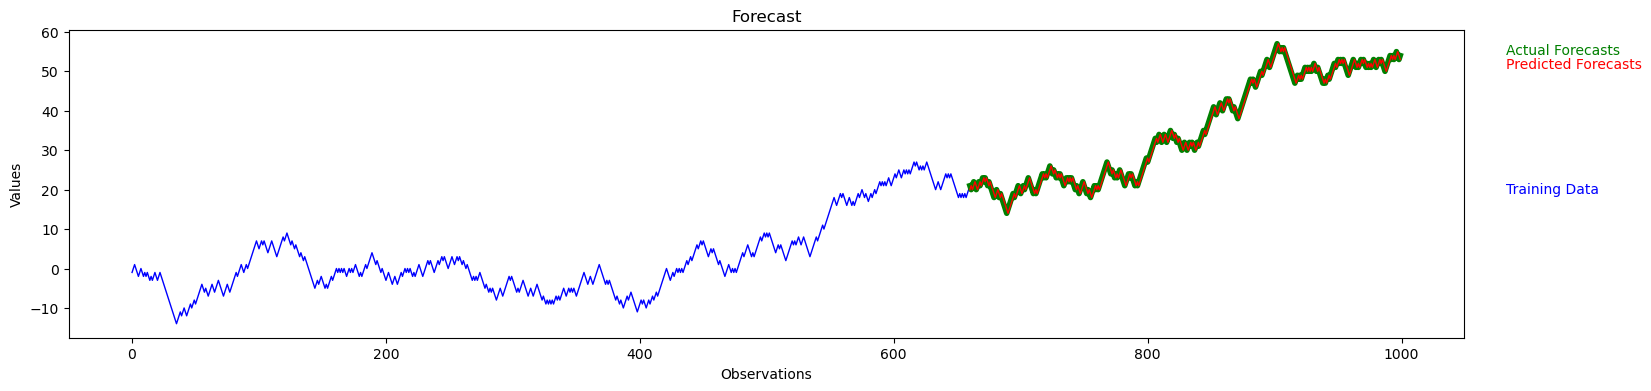

In [22]:
EvaluationMetric.plot_forecast(train_data_df, expected_forecasts_df, rw_predictions, per_element=False)

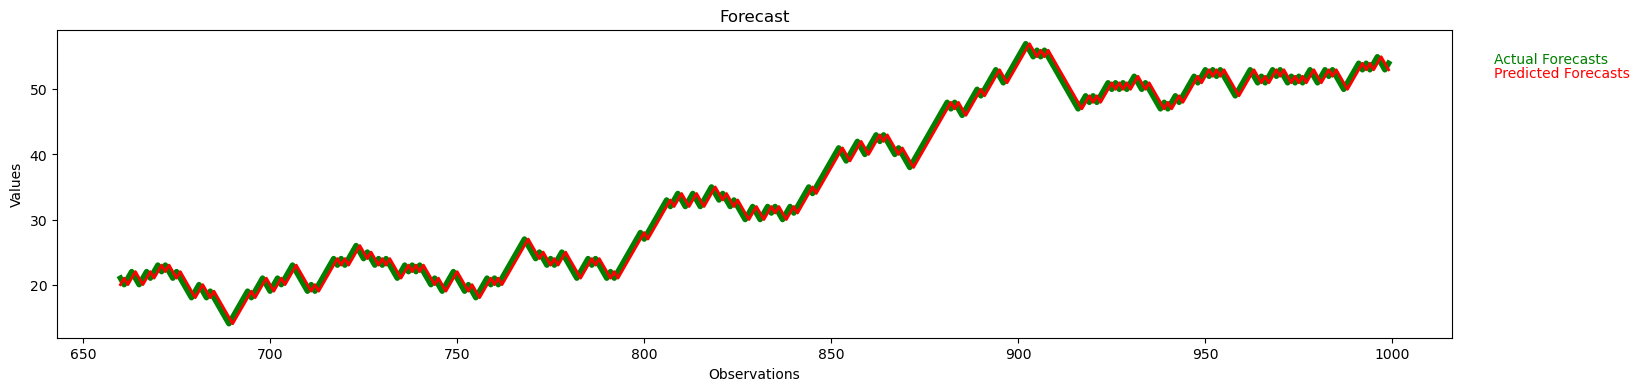

In [23]:
EvaluationMetric.plot_forecast_only(expected_forecasts_df, rw_predictions, per_element=False)

### Difference

In [22]:
differenced_generated_stationary_ts = generated_stationary_ts.data_augment_with_differencing(1)

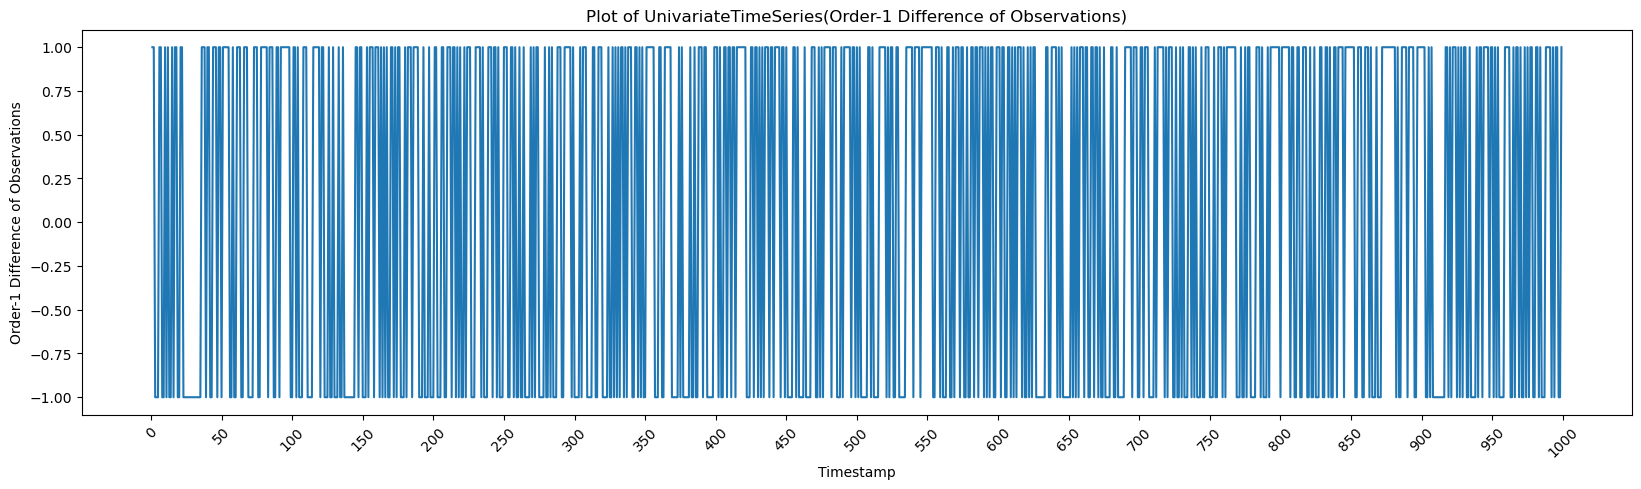

In [23]:
differenced_generated_stationary_ts.plot(tick_skip=50)

- This is expected since we generated the series.
- We have no information to work with other than a series of random moves.

### Get Descriptive Statistics of Differenced Data

In [24]:
differenced_generated_stationary_ts.get_statistics()

,Order-1 Difference of Observations
count,999.000000
mean,0.055055
std,0.998983
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [25]:
differenced_generated_stationary_ts.max_min_range()

{'Max': Order-1 Difference of Observations    1.0
 dtype: float64,
 'Min': Order-1 Difference of Observations   -1.0
 dtype: float64,
 'Range': Order-1 Difference of Observations    2.0
 dtype: float64}

### Check Stationarity of Difference Data

In [26]:
differenced_generated_stationary_ts.stationarity_test(gsts_df)

ADF Statistic: -31.084824
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### Plot Autocorrelation and Partial Autocorrelation of Difference Data

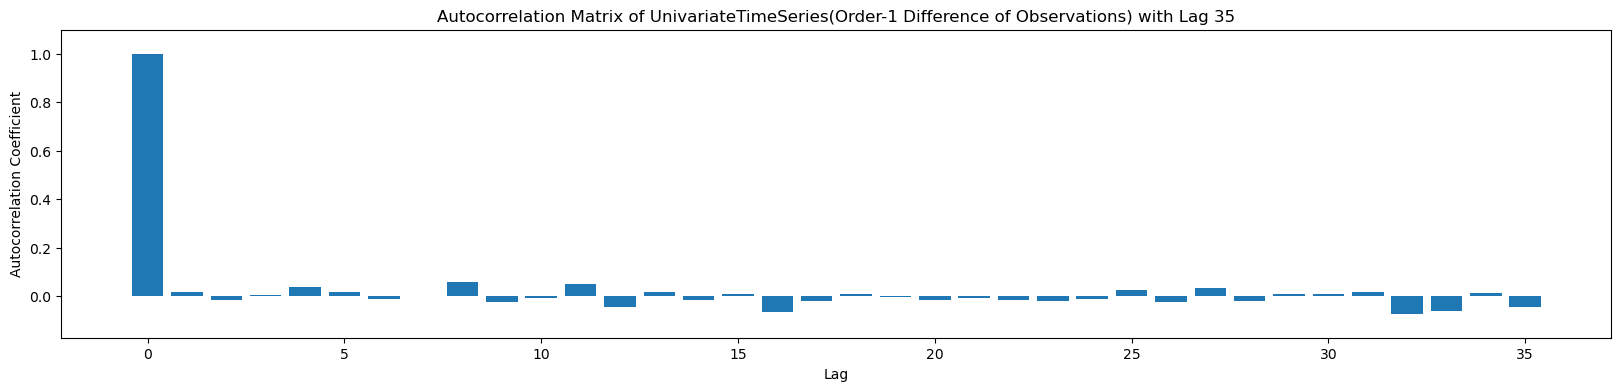

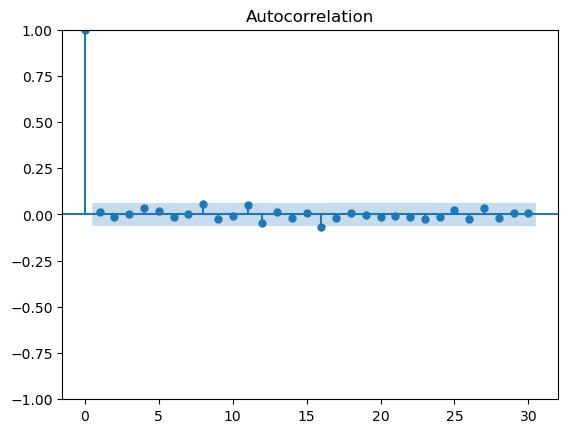

In [27]:
differenced_generated_stationary_ts.plot_autocorrelation(35)

- Exponentially dies out at lag 1, so no correlation between $ z_0 $  and $ z_1 $. With this, there doesn't exists any correlation between $ z_0 $ and the remaining $ z_{t - 1} $.

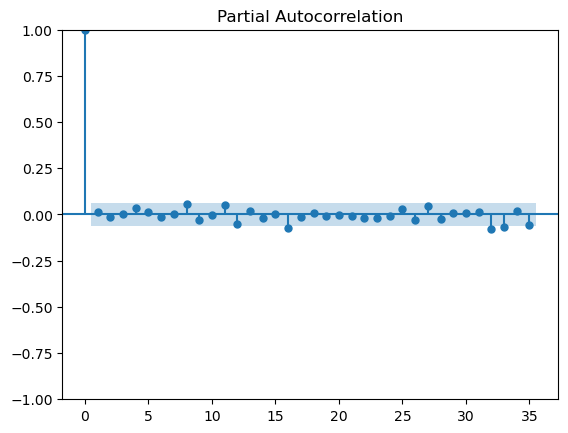

In [28]:
differenced_generated_stationary_ts.plot_partial_autocorrelation(35)

- Exponentially dies out at lag 1, so no correlation between $ z_0 $  and $ z_1 $.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

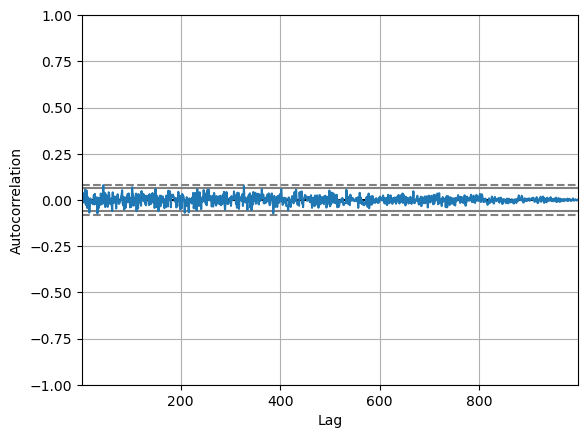

In [29]:
autocorrelation_plot(differenced_generated_stationary_ts.get_series())

### Split Data
- Splitting so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [30]:
# train_size = int(len(differenced_generated_stationary_ts.get_series()) * 0.66)
# train, test = differenced_generated_stationary_ts.get_series()[0:train_size], differenced_generated_stationary_ts.get_series()[train_size:]
# len(train), len(test), len(test) - len(train)

In [31]:
train_returns, validation_returns, test_returns = generated_stationary_ts.get_train_validation_test_split(0.66, 0.0)

0 660
660 660
660 1000


In [32]:
len(train_returns) - len(test_returns)

320

In [33]:
train_data_df = train_returns.get_as_df()
train_data_df

,UnivariateTimeSeries(Observations)[0:660]
Timestamp,
0,-1
1,0
2,1
3,0
4,-1
...,...
655,18
656,19
657,18


In [34]:
train_returns_data_series = train_returns.get_series()
train_returns_data_series

array([ -1,   0,   1,   0,  -1,  -2,  -1,   0,  -1,  -2,  -1,  -2,  -1,
        -2,  -3,  -2,  -3,  -2,  -1,  -2,  -3,  -2,  -1,  -2,  -3,  -4,
        -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -13, -12, -11,
       -12, -11, -10, -11, -12, -11, -10,  -9, -10,  -9,  -8,  -9,  -8,
        -7,  -6,  -5,  -4,  -5,  -6,  -5,  -6,  -7,  -6,  -5,  -4,  -5,
        -6,  -5,  -4,  -3,  -4,  -5,  -6,  -7,  -6,  -5,  -4,  -5,  -6,
        -5,  -4,  -3,  -2,  -1,  -2,  -1,   0,   1,   0,  -1,   0,   1,
         0,   1,   2,   3,   4,   5,   6,   7,   6,   5,   6,   7,   6,
         7,   6,   5,   4,   5,   6,   7,   6,   5,   4,   3,   4,   5,
         6,   7,   8,   7,   8,   9,   8,   7,   6,   7,   6,   5,   6,
         5,   4,   3,   4,   3,   2,   3,   2,   1,   0,  -1,  -2,  -3,
        -4,  -5,  -4,  -3,  -4,  -3,  -2,  -3,  -4,  -5,  -4,  -5,  -4,
        -3,  -2,  -3,  -2,  -1,   0,  -1,   0,  -1,   0,  -1,   0,  -1,
        -2,  -1,   0,  -1,   0,  -1,   0,   1,   0,  -1,  -2,  -

In [35]:
test_returns.get_as_df()

,UnivariateTimeSeries(Observations)[660:1000]
Timestamp,
660,21
661,20
662,21
663,22
664,21
...,...
995,54
996,55
997,54


In [36]:
expected_forecasts_on_returns = test_returns.get_series()
len(expected_forecasts_on_returns), expected_forecasts_on_returns

(340,
 array([21, 20, 21, 22, 21, 20, 21, 22, 21, 22, 23, 22, 23, 22, 21, 22, 21,
        20, 19, 18, 19, 20, 19, 18, 19, 18, 17, 16, 15, 14, 15, 16, 17, 18,
        19, 18, 19, 20, 21, 20, 19, 20, 21, 20, 21, 22, 23, 22, 21, 20, 19,
        20, 19, 20, 21, 22, 23, 24, 23, 24, 23, 24, 25, 26, 25, 24, 25, 24,
        23, 24, 23, 24, 23, 22, 21, 22, 23, 22, 23, 22, 23, 22, 21, 20, 21,
        20, 19, 20, 21, 22, 21, 20, 19, 20, 19, 18, 19, 20, 21, 20, 21, 20,
        21, 22, 23, 24, 25, 26, 27, 26, 25, 24, 25, 24, 23, 24, 23, 24, 25,
        24, 23, 22, 21, 22, 23, 24, 23, 24, 23, 22, 21, 22, 21, 22, 23, 24,
        25, 26, 27, 28, 27, 28, 29, 30, 31, 32, 33, 32, 33, 34, 33, 32, 33,
        34, 33, 32, 33, 34, 35, 34, 33, 34, 33, 32, 33, 32, 31, 30, 31, 32,
        31, 30, 31, 32, 31, 32, 31, 30, 31, 32, 31, 32, 33, 34, 35, 34, 35,
        36, 37, 38, 39, 40, 41, 40, 39, 40, 41, 42, 41, 40, 41, 42, 43, 42,
        43, 42, 41, 40, 41, 40, 39, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
      

### Initialize Autoregressive AR(p) Model
- How to determine the proper lag value? Look at the Partial ACor plot. Being that we're out of the blue area at lag 3, we'll set our lag to be 3. 
    - Why Partial ACor plot and not ACor plot?
    - What if we take lags from ACor plot anyway? Say lags 5, 10, and 15 because they all have the most correlation (postive and negative) for their clusters, respectfully.
- How to understand the model summary?

In [37]:
lags_to_test = [1]

In [38]:
len(train_returns_data_series), len(expected_forecasts_on_returns)

(660, 340)

In [39]:
ar_model_class = AR()

trained_ar_models = ar_model_class.train_ar_model(train_returns.get_series(), lags_to_test)

In [40]:
len_historical_data, historical_data = train_returns.get_historical_data()
len_historical_data

660

### Predict Forecasts

In [41]:
ar_predictions = ar_model_class.predict(trained_ar_models, len_historical_data, train_returns_data_series, expected_forecasts_on_returns)
ar_predictions

TypeError: predict() takes 4 positional arguments but 5 were given

In [ ]:
ar_mse_gsts = EvaluationMetric.eval_mse(expected_forecasts_on_returns, ar_predictions)
ar_mse_gsts

In [ ]:
ar_rmse_gsts = EvaluationMetric.eval_rmse(expected_forecasts_on_returns, ar_predictions)
ar_rmse_gsts

### Plot Actual Forecasts vs Predicted Forecasts

In [ ]:
EvaluationMetric.plot_forecast(expected_forecasts_on_returns, ar_predictions, lags_to_test)

### Follow-up
- What can we determine from this?
- Which AR(p) lag performs the best?
- Can we do better?